### 3.0 Cluster Analysis and Topic Modelling
In this notebook a quantitative analysis is performed on the dataset in order to cluster for more concrete religious themes and find possible correlations between other variables, such like year, law references or lawyers.

In [117]:
# Import packages
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import re
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

from sklearn.cluster import KMeans

# Text analysis
import re
import nltk 
from nltk import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords
import spacy
nlp = spacy.load("de_core_news_sm")
stop_words = set(stopwords.words("german"))

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Topic Modelling, Embeddings etc.
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\25mad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\25mad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# pip install tqdm
# pip install wordcloud

In [5]:
religious_keywords = ["glaubensfreiheit", "religiös", "religion", "religionsgemeinschaft", "religionsfreiheit",
                      "gott", "christentum", "kirche", "bibel",
                      "islam", "moschee", "kopftuch","koran",
                      "tora", "synagoge", 
                     ]

In [214]:
religious_df = pd.read_csv("data/df_religious_prepped.csv")
normal_df = pd.read_csv("data/df_normal_prepped.csv")
print(normal_df.shape)
religious_df.head()


(8804, 20)


,text,url_html,clean_w_numbers,gesetzesverweise,clean_wo_numbers,datum,entscheidungsjahr,entscheidung_typ,spruchkoerper_typ,registerzeichen,...,processed_wo_numbers,text_lemma,religious_terms_count,religious_terms_detail,has_religious_content,has_christentum,has_islam,has_judentum,has_allgemein,text_lemma_filtered
0,BUNDESVERFASSUNGSGERICHT\n\n- 2 BvL 3/20 -\n\n...,https://www.bundesverfassungsgericht.de/Shared...,den Verkehr mit Betäubungsmitteln für verfassu...,['Art. 2 Abs. 1 — auch in Verbindung mit Art. ...,den Verkehr mit Betäubungsmitteln für verfassu...,1996-01-11 00:00:00,1996,B,K,BvR,...,verkehr betäubungsmitteln verfassungswidrig um...,Verkehr betäubungsmitteln verfassungswidrig Um...,1,{'glaubensfreiheit': 1},True,0,0,0,1,Verkehr betäubungsmitteln verfassungswidrig Um...
1,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 1889/23 -\...,https://www.bundesverfassungsgericht.de/Shared...,"die Verfassungsbeschwerde des Herrn , gegen a)...","['§ 93b in Verbindung mit § 93a BVerfGG', 'Art...",die Verfassungsbeschwerde des Herrn gegen den ...,1998-02-13 00:00:00,1998,B,K,BvR,...,verfassungsbeschwerde herrn amtsgerichts heins...,Verfassungsbeschwerde Herr Amtsgerichts heinsb...,1,{'gott': 1},True,1,1,1,1,Amtsgerichts heinsberg amtsgerichts heinsberg ...
2,Leitsätz...,https://www.bundesverfassungsgericht.de/Shared...,"den Antrag festzustellen, dass die Nationaldem...",['§ 18 Abs. 4 Satz 1 Halbsatz 2 PartG muss die...,den Antrag festzustellen dass die Nationaldemo...,1998-03-19 00:00:00,1998,B,K,BvR,...,antrag festzustellen nationaldemokratische par...,Antrag feststellen nationaldemokratisch Partei...,1,{'religion': 1},True,0,0,0,1,feststellen nationaldemokratisch Partei Deutsc...
3,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 2231/23 -\...,https://www.bundesverfassungsgericht.de/Shared...,die Verfassungsbeschwerde der Bevollmächtigte:...,['§ 93d Abs. 1 Satz 3 BVerfGG'],die Verfassungsbeschwerde der Bevollmächtigte ...,1998-05-26 00:00:00,1998,B,K,BvR,...,verfassungsbeschwerde bevollmächtigte azr vere...,Verfassungsbeschwerde bevollmächtigen azr Vere...,1,{'religiös': 1},True,0,0,0,1,bevollmächtigen azr Verein handele religions s...
4,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 2244/23 -\...,https://www.bundesverfassungsgericht.de/Shared...,die Verfassungsbeschwerde des Bevollmächtigte:...,['§ 93d Abs. 1 Satz 3 BVerfGG'],die Verfassungsbeschwerde des Bevollmächtigte ...,1998-05-26 00:00:00,1998,B,K,BvR,...,verfassungsbeschwerde bevollmächtigte azr vere...,Verfassungsbeschwerde bevollmächtigen azr Vere...,1,{'religiös': 1},True,0,0,0,1,bevollmächtigen azr Verein handele religions s...


### 1.0 Keyword Analysis
Was sind die häufigsten Wörter innerhalb von den religiösen Entscheidungen? 

In [217]:
filter_list = ["beschwerdeführer", "beschwerdeführerin", "antragsteller", "antragstellerin", "antrag", "erlass", "anordnung",
               "deutsch", "antragsgegnerin", "verfassungsrechtlich", "gesetzgeber", "regelung", "staatlich",
               "entscheidung", "bvr", "artikel", "absatz", "verfassungsbeschwerde", "herr", "bekanntmachung", "einstweilig", "einstimmig",
               "buchstabe", "fassung", "beschließen", "annehmen", "verfahren"
               ]

normal_df.loc[:,"text_lemma_filtered"] = normal_df.loc[:,"text_lemma"].apply(
    lambda text: ' '.join([word for word in text.split() if word.lower() not in filter_list])
)

In [ ]:
non_religious_tokens = ' '.join(normal_df['text_lemma_filtered']).lower().split()
religious_tokens = ' '.join(religious_df['text_lemma_filtered']).lower().split()

all_counts = Counter(non_religious_tokens)
religious_counts = Counter(religious_tokens)

total_words = sum(all_counts.values())
total_religious_words = sum(religious_counts.values())
all_words = set(all_counts.keys()).union(religious_counts.keys())

data = []
for word in all_words:
    rel_freq_all = all_counts[word] / total_words
    rel_freq_religious = religious_counts[word] / total_religious_words
    # for ratio to not be null add small number
    ratio = (rel_freq_religious + 0.001) / (rel_freq_all + 0.001) 
    data.append((word, rel_freq_all, rel_freq_religious, ratio))

df_compare = pd.DataFrame(data, columns=['word', 'freq_all', 'freq_religious', 'rel_ratio'])

df_compare_sorted = df_compare.sort_values(by='rel_ratio', ascending=False)


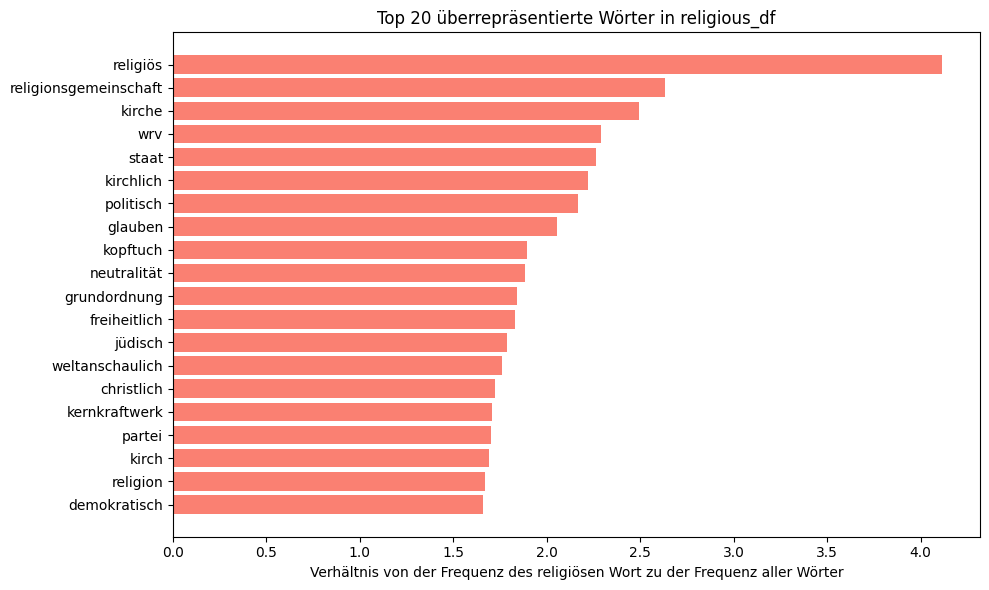

In [224]:
top_words = df_compare_sorted.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_words['word'], top_words['rel_ratio'], color='salmon')
plt.xlabel('Verhältnis von der Frequenz des religiösen Wort zu der Frequenz aller Wörter')
plt.title(f'Top 20 überrepräsentierte Wörter in religious_df')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Die Verbildlichung von den überrepräsentierten Wörtern zeigt besonders in den ersten 10 Ähnlichkeiten zu den Artikeln, die dabei häufig zitiert werden.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(religious_df["text_lemma_filtered"])
feature_names = vectorizer.get_feature_names_out()

def get_top_keywords(row_idx, top_n=5):
    row = tfidf_matrix[row_idx]
    scores = row.toarray().flatten()
    top_indices = scores.argsort()[::-1][:top_n]
    return [feature_names[i] for i in top_indices if scores[i] > 0]

religious_df["top_keywords"] = [get_top_keywords(i, top_n=10) for i in range(tfidf_matrix.shape[0])]

In [23]:
religious_df[["text_lemma_filtered", "top_keywords"]].head()

,text_lemma_filtered,top_keywords
0,Verkehr betäubungsmitteln verfassungswidrig Um...,"[btmg, betäubungsmittel, gramm, unerlaubt, can..."
1,Amtsgerichts heinsberg amtsgerichts heinsberg ...,"[kind, familiengerichen, umgangsausschluss, um..."
2,feststellen nationaldemokratisch Partei Deutsc...,"[partei, freiheitlich, demokratisch, grundordn..."
3,bevollmächtigen azr Verein handele religions s...,"[verein, meßling, yogaprodukt, vertriebs, semi..."
4,bevollmächtigen azr Verein handele religions s...,"[verein, meßling, yogaprodukt, vertriebs, semi..."


[('religiös', 10), ('oberlandesgericht', 10), ('politisch', 9), ('äußerung', 9), ('kind', 8), ('schüler', 8), ('kirchlich', 8), ('religionsunterricht', 8), ('religionsgemeinschaft', 8), ('staat', 7), ('bayerisch', 7), ('wrv', 7), ('kopftuch', 7), ('eltern', 6), ('brandenburg', 6), ('auslieferung', 6), ('verein', 5), ('schule', 5), ('asylvfg', 5), ('kirche', 5)]


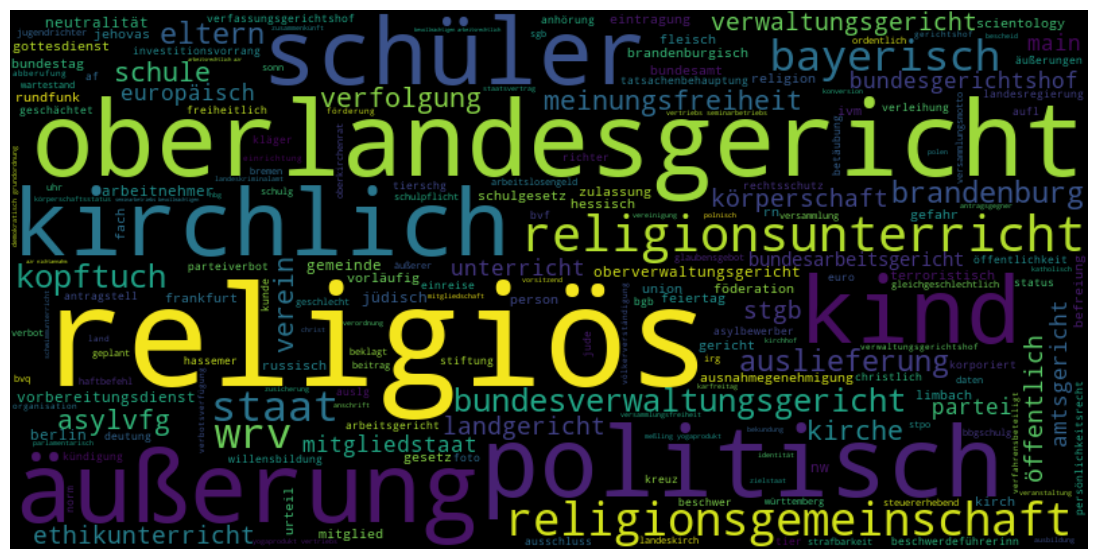

In [24]:
# visualize top keywords after all 
all_keywords = [kw for sublist in religious_df["top_keywords"] for kw in sublist]
keyword_freq = Counter(all_keywords)
print(keyword_freq.most_common(20))

text = ' '.join(all_keywords)
wordcloud = WordCloud(width=800, height=400).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Sehr auffällig aus den bestehenden Schlüsselwörtern scheinen hier die Begriffe Kind, Religionsunterricht, Auslieferung, Religionsgemeinschaft, Partei sowie spezielle Begriffe wie Kopftuch und politisch zu sein. 
Dies ist aber vor dem Hintergrund der sog. Kopftuch-Urteile nicht allzu verwunderlich.

<Axes: xlabel='entscheidungsjahr'>

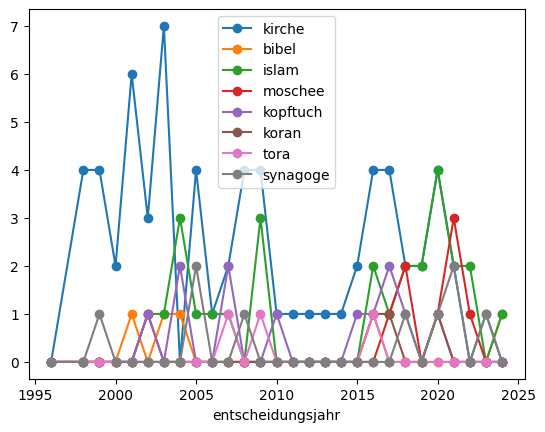

In [50]:
# Only take more specific words
for begriff in religious_keywords[7::]:
    religious_df[begriff] = religious_df['text_lemma_filtered'].str.lower().str.contains(begriff)

zeitverlauf = religious_df.groupby(religious_df['entscheidungsjahr'])[religious_keywords[7::]].sum()
zeitverlauf.plot(kind='line', marker='o')

### 2.0 Topic Modelling

In [ ]:
religious_df['tokenized_text'] = religious_df['text_lemma_filtered'].apply(word_tokenize)
tokens = religious_df['tokenized_text'].tolist()

In [253]:
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(religious_df['text_lemma_filtered'])

In [264]:
# Changed by testing
n_topics = 4
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=30
)
lda.fit(count_data)

LatentDirichletAllocation(max_iter=30, n_components=4, random_state=42)

In [265]:
print("Top-Wörter pro Thema:")
feature_names = count_vectorizer.get_feature_names_out()
n_top_words = 10
topic_words = []

for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    topic_words.append(top_words)
    print(f"Thema {topic_idx}: {', '.join(top_words)}")

Top-Wörter pro Thema:
Thema 0: frage, bundesamt, asylvfg, drittstaat, staat, können, verwaltungsgericht, prüfung, schutz, land
Thema 1: politisch, partei, mitglied, demokratisch, europäisch, jahr, person, ziel, auslieferung, freiheitlich
Thema 2: religiös, öffentlich, staat, grundrecht, gesetz, religionsgemeinschaft, angegriffen, kirchlich, urteil, kirche
Thema 3: land, daten, rasterfahndung, person, schutz, betroffen, jahr, gemeinde, grundrecht, gefahr


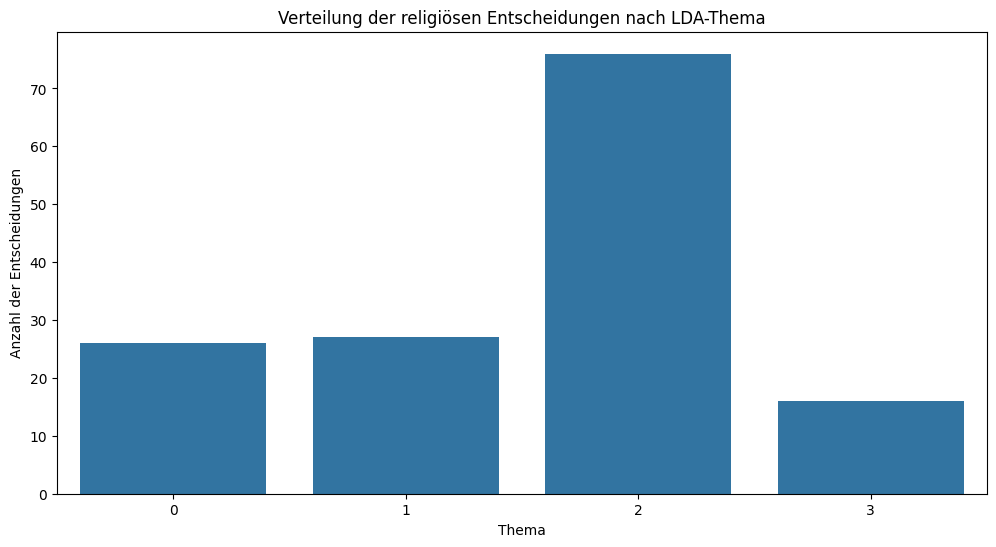

In [266]:
doc_topic_dist = lda.transform(count_data)
religious_df['dominant_topic'] = doc_topic_dist.argmax(axis=1)

plt.figure(figsize=(12, 6))
topic_counts = religious_df['dominant_topic'].value_counts().sort_index()
sns.barplot(x=topic_counts.index, y=topic_counts.values)
plt.title('Verteilung der religiösen Entscheidungen nach LDA-Thema')
plt.xlabel('Thema')
plt.ylabel('Anzahl der Entscheidungen')
plt.savefig('topic_distribution.png')


In [267]:
import ast
law_references_by_topic = {}

for topic in range(0,n_topics+1):
    df_theme = religious_df[religious_df["dominant_topic"] == topic]
    
    law_refs = df_theme['gesetzesverweise'].dropna().apply(ast.literal_eval)
    flat_list = [item for sublist in law_refs for item in sublist]
    top_laws = Counter(flat_list).most_common(5)
    law_references_by_topic[topic] = dict(top_laws)

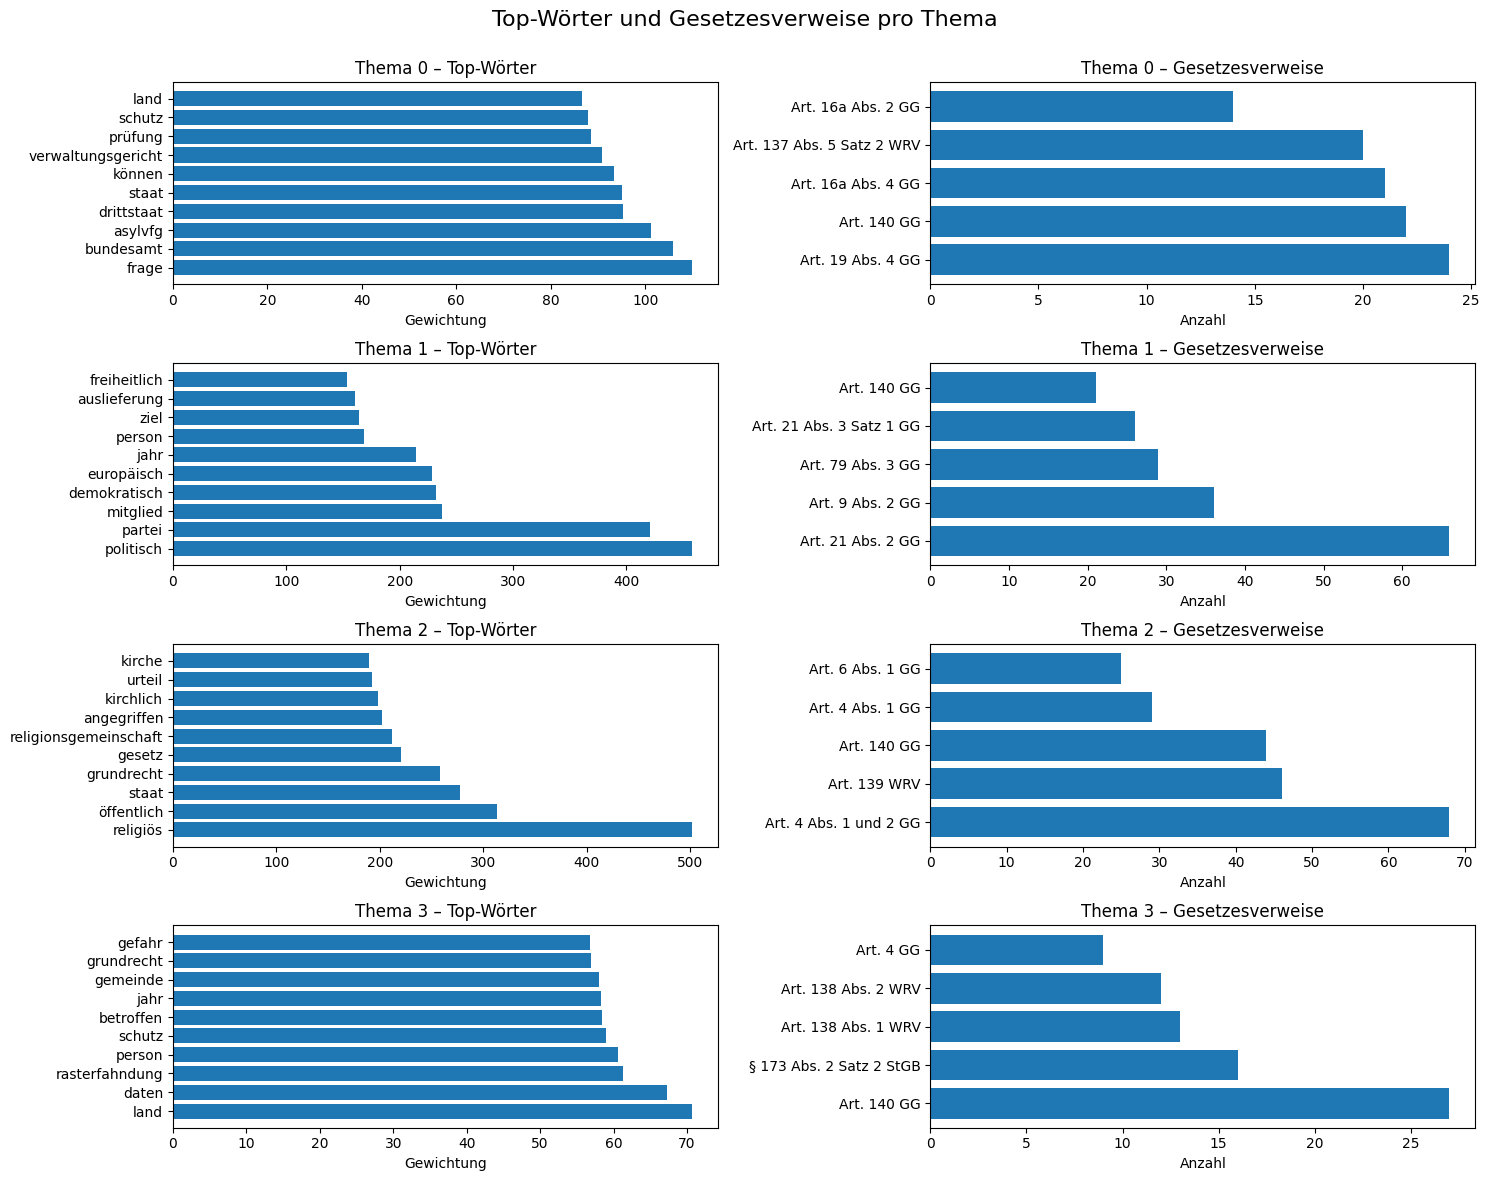

In [269]:
fig, axes = plt.subplots(n_topics, 2, figsize=(15, n_topics * 3), sharex=False)
fig.suptitle('Top-Wörter und Gesetzesverweise pro Thema', fontsize=16)

for i, (topic_dist, (ax_words, ax_laws)) in enumerate(zip(lda.components_, axes)):
    
    top_word_indices = topic_dist.argsort()[:-11:-1]
    top_words = [feature_names[idx] for idx in top_word_indices]
    top_weights = [topic_dist[idx] for idx in top_word_indices]

    ax_words.barh(top_words, top_weights)
    ax_words.set_title(f'Thema {i} – Top-Wörter')
    ax_words.set_xlabel('Gewichtung')

    gesetzesverweise = law_references_by_topic[i]
    if gesetzesverweise:
        laws = list(gesetzesverweise.keys())
        counts = list(gesetzesverweise.values())
        ax_laws.barh(laws, counts)
        ax_laws.set_title(f'Thema {i} – Gesetzesverweise')
        ax_laws.set_xlabel('Anzahl')
    else:
        ax_laws.set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('topic_words_laws.png')
plt.show()

Man erkennt hier ähnliche Trends zu vorherigen Abbildungen. Die Themen-Modellierung hier ist allerdings ein wenig spezieller, und wird können unsere vorherige Gruppierung in "Allgemein", "Islam", "Judentum", und "Christentum" ein wenig spezifischer gestalten. Für die Themen wäre folgende Charakterisierung denkbar:

0. Politische Auslieferung
1. Kirchlich geprägte Urteile
2. Religion im Unterricht
3. Religiös-öffentliche Äußerung



#### 2.0 Word Embeddings
Um den Kontext von religiösen Entscheidungen besser analysieren zu können und Cluster zu erstellen, wird in dieser Sektion nach Sätzen, die religiöse Schlüsselwörter beinhalten und anschließend eine Clusteranalyse durchgeführt.

In [54]:
# Tokenize sentences, then lemmatize to extract only such that have religious keywords inside of them
def get_religious_sentences_lemmatized(text):
    raw_sentences = sent_tokenize(text, language="german")
    matches = []

    for sent in raw_sentences:
        doc = nlp(sent)
        lemmas = [token.lemma_.lower() for token in doc]
        if any(kw in lemmas for kw in religious_keywords):
            matches.append(sent)
    
    return matches

In [55]:
religious_df['contexts_rel_sentences'] = religious_df['clean_w_numbers'].apply(get_religious_sentences_lemmatized)

In [59]:
religious_df[['contexts_rel_sentences']].head()

,contexts_rel_sentences
0,[6 Abs. 1 und 2 GG und – ohne nähere Erörterun...
1,"[Außerdem mache er ihnen Vorhaltungen, dass ih..."
2,[Die unbedingte Unterordnung einer Person unte...
3,[die Verfassungsbeschwerde der Bevollmächtigte...
4,[die Verfassungsbeschwerde des Bevollmächtigte...


In [60]:
lst_stopwords = nltk.corpus.stopwords.words("german")
with open("extended_stopwords.txt", "r", encoding="utf-8") as f:
    custom_stopwords = set(f.read().splitlines())
with open("german_stopwords_full.txt", "r", encoding="utf-8") as f:
    german_stopwords_extended = set(f.read().splitlines())

# Function to remove punctuation and stopwords
def utils_preprocess_text_stopwords(text):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    lst_text = text.split() 
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in german_stopwords_extended and word not in lst_stopwords and word not in custom_stopwords]
    
    text = " ".join(lst_text)
    return text

In [61]:
sentences = [sent for sublist in religious_df["contexts_rel_sentences"].dropna() for sent in sublist]
cleaned_sentences = [utils_preprocess_text_stopwords(sent) for sent in sentences]

In [ ]:
from sentence_transformers import SentenceTransformer

# TODO maybe change model later on?
model = SentenceTransformer("distiluse-base-multilingual-cased")
sentence_embeddings = model.encode(cleaned_sentences, show_progress_bar=True)

c:\Users\25mad\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]


In [201]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean')
labels_hdbscan = clusterer.fit_predict(sentence_embeddings)

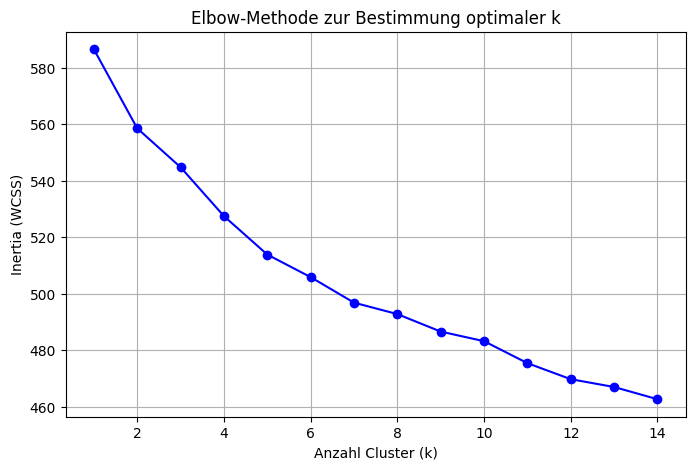

In [202]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(sentence_embeddings)
    wcss.append(kmeans.inertia_) 

plt.figure(figsize=(8, 5))
plt.plot(K, wcss, 'bo-', markersize=6)
plt.xlabel("Anzahl Cluster (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow-Methode zur Bestimmung optimaler k")
plt.grid(True)
plt.show()

In [203]:
from sklearn.cluster import KMeans

# Although elbow shows 6, after visualizing 5 seems more appropriate
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
labels_kmeans = kmeans.fit_predict(sentence_embeddings)

In [204]:
df_sentences = religious_df.copy()
df_sentences = df_sentences.explode("contexts_rel_sentences").reset_index()

df_sentences["satz"] = df_sentences["text_lemma_filtered"]
df_sentences["hdbscan"] = labels_hdbscan
df_sentences["kmeans"] = labels_kmeans

In [205]:
for method in ['hdbscan', 'kmeans']:
    print(f"\n===== TOP WORDS for {method.upper()} clusters =====")
    for label in sorted(df_sentences[method].unique()):
        cluster_sätze = df_sentences[df_sentences[method] == label]['satz']
        all_words = ' '.join(cluster_sätze).lower().split()
        word_counts = Counter(all_words)
        print(f"\nCluster {label}:")
        print(", ".join([word for word, freq in word_counts.most_common(10)]))



===== TOP WORDS for HDBSCAN clusters =====

Cluster -1:
religiös, staat, kopftuch, öffentlich, neutralität, kirchlich, grundrecht, land, glauben, kirche

Cluster 0:
religiös, kopftuch, öffentlich, staat, eltern, schule, schüler, unterricht, symbol, glaubensfreiheit

Cluster 1:
öffentlich, land, wrv, religiös, körperschaft, religionsgemeinschaft, staat, vereinigung, verbot, grundrecht

Cluster 2:
religiös, staat, öffentlich, kopftuch, neutralität, religionsgemeinschaft, grundrecht, glauben, land, schule

Cluster 3:
religiös, kopftuch, staat, neutralität, öffentlich, weltanschaulich, glauben, tätigkeit, schule, können

===== TOP WORDS for KMEANS clusters =====

Cluster 0:
kirchlich, religiös, kirche, staat, urteil, arbeitnehmer, öffentlich, kirch, einrichtung, katholisch

Cluster 1:
religiös, politisch, kopftuch, staat, partei, neutralität, demokratisch, öffentlich, schule, nw

Cluster 2:
religiös, staat, öffentlich, kopftuch, neutralität, grundrecht, schule, religionsgemeinschaft, glau

In [207]:
law_references_by_cluster_kmeans = {}
law_references_by_cluster_hbdscan = {}

for cluster in range(0,5):
    df_theme = df_sentences[df_sentences["kmeans"] == cluster]
    
    law_refs = df_theme['gesetzesverweise'].dropna().apply(ast.literal_eval)
    flat_list = [item for sublist in law_refs for item in sublist]
    top_laws = Counter(flat_list).most_common(5)
    law_references_by_cluster_kmeans[cluster] = dict(top_laws)

for cluster in range(-1,4):
    df_theme = df_sentences[df_sentences["hdbscan"] == cluster]
    
    law_refs = df_theme['gesetzesverweise'].dropna().apply(ast.literal_eval)
    flat_list = [item for sublist in law_refs for item in sublist]
    top_laws = Counter(flat_list).most_common(5)
    law_references_by_cluster_hbdscan[cluster] = dict(top_laws)

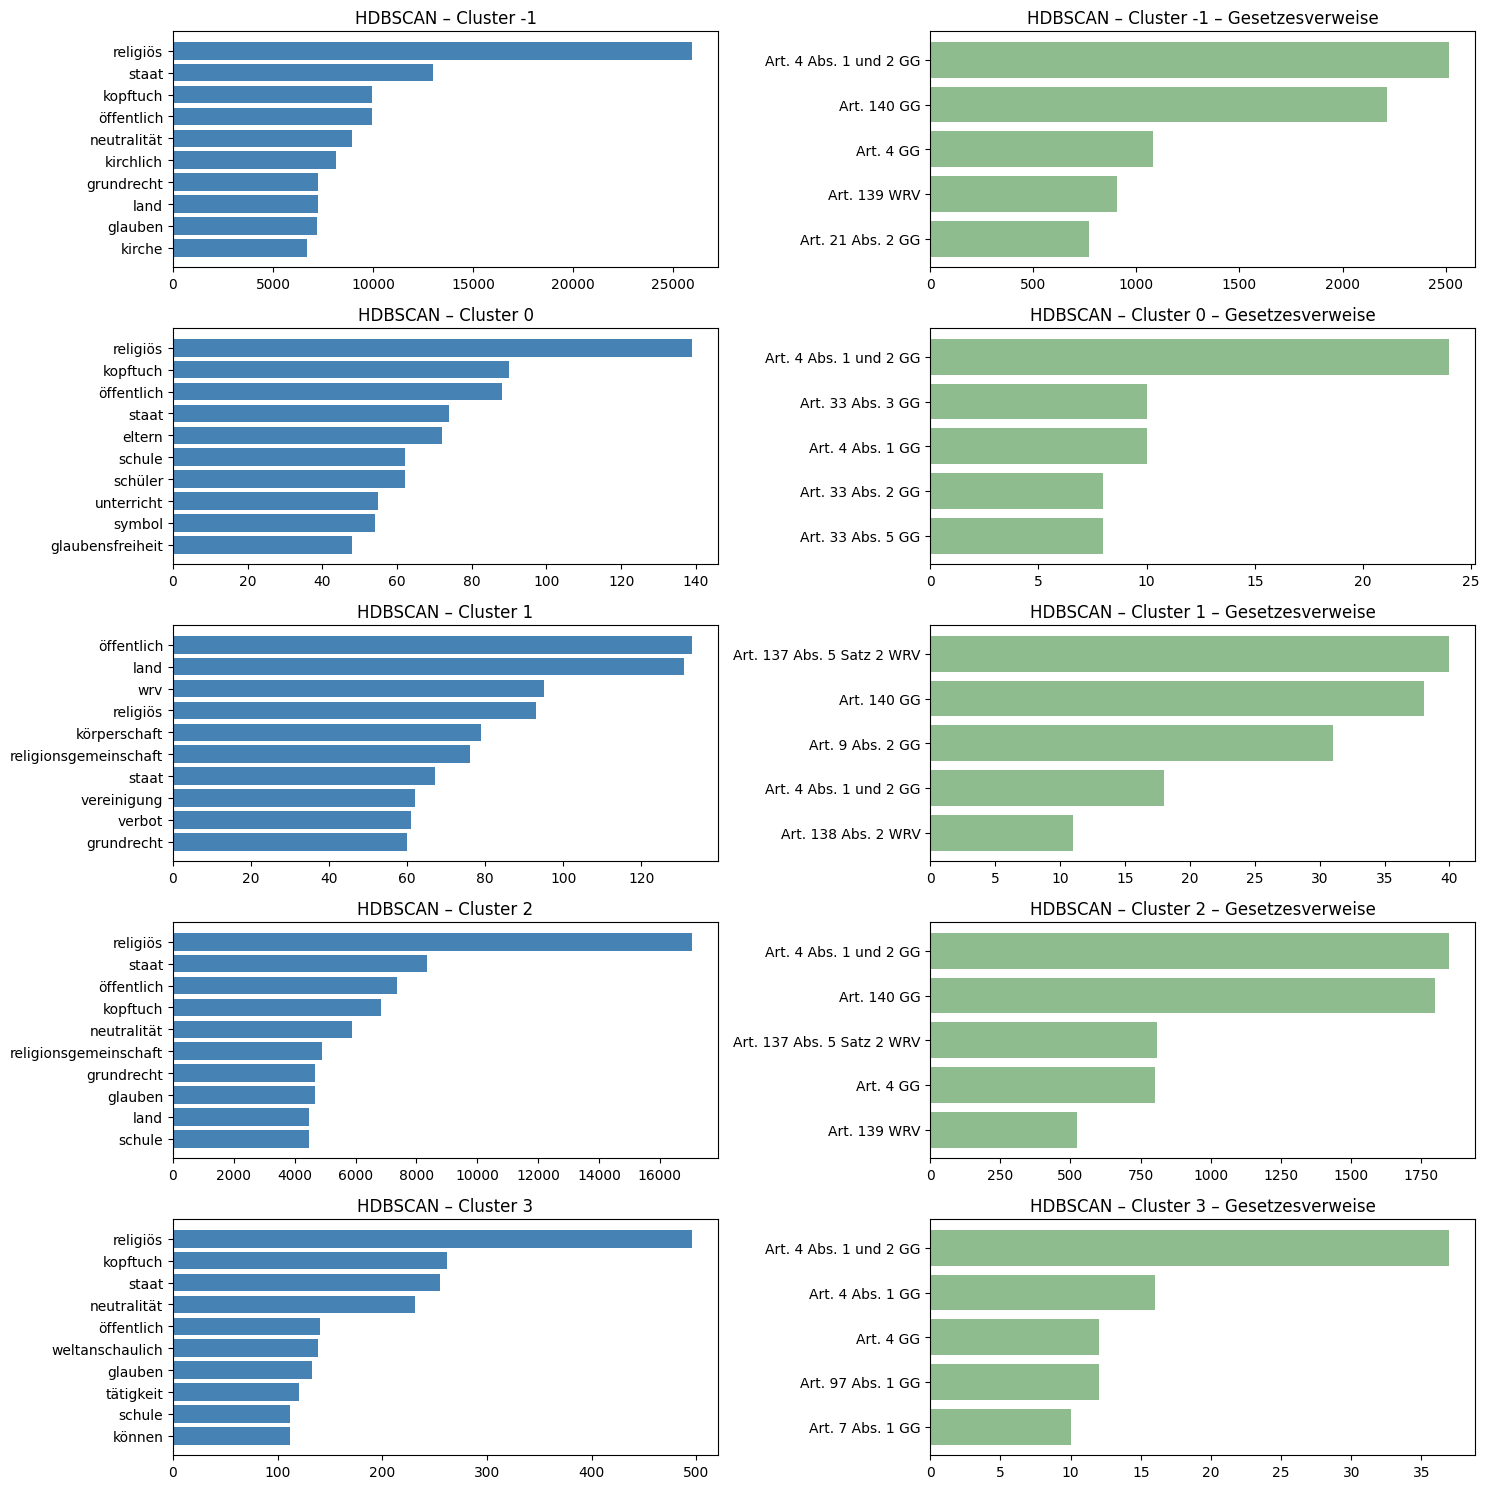

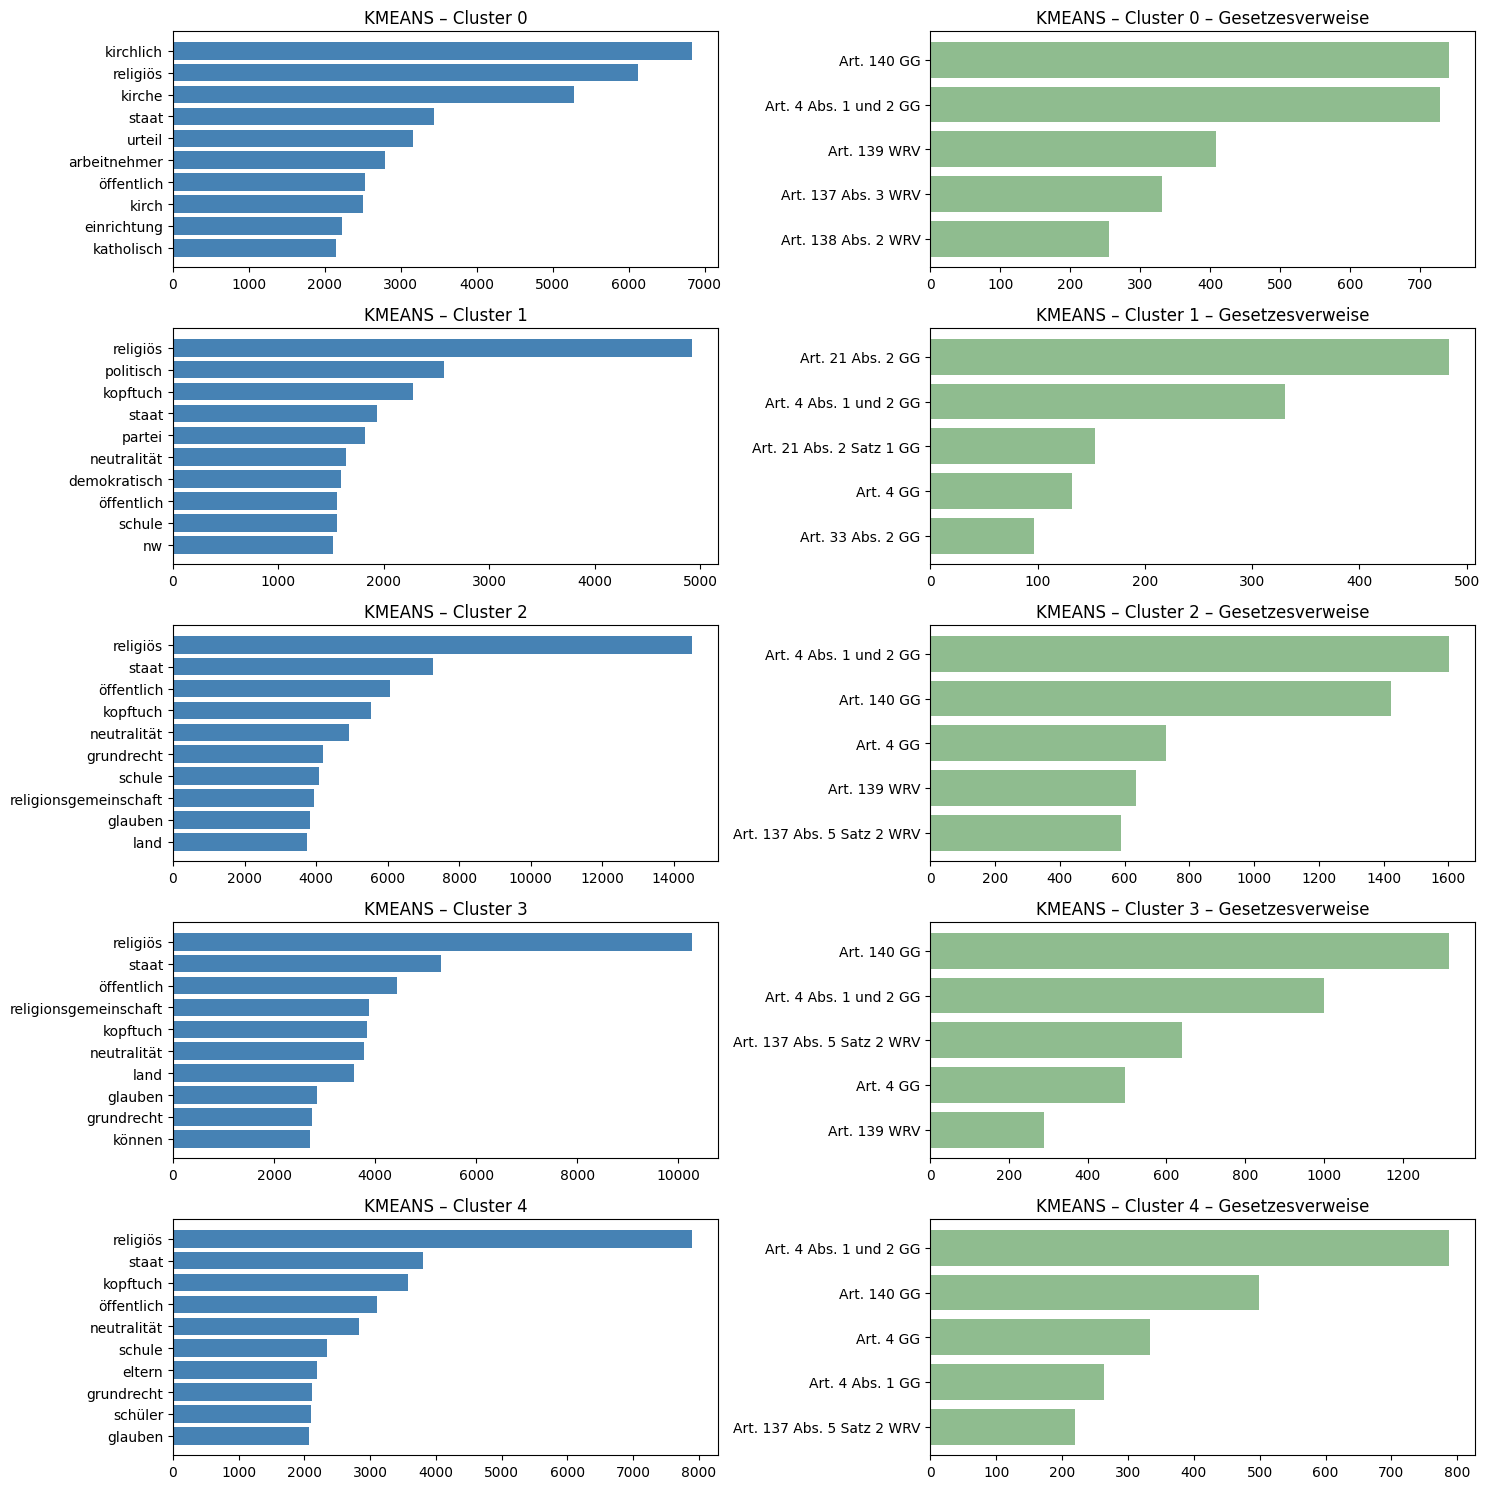

In [208]:
law_references_by_cluster = {
    'kmeans': law_references_by_cluster_kmeans,
    'hdbscan': law_references_by_cluster_hbdscan
}

for method in ['hdbscan', 'kmeans']:
    cluster_labels = sorted(df_sentences[method].dropna().unique())
    law_refs_dict = law_references_by_cluster[method]

    n_clusters = len(cluster_labels)
    fig, axes = plt.subplots(n_clusters, 2, figsize=(15, n_clusters * 3))

    if n_clusters == 1:
        axes = [axes]

    for i, label in enumerate(cluster_labels):
        cluster_sätze = df_sentences[df_sentences[method] == label]['satz']
        all_words = ' '.join(cluster_sätze).lower().split()
        word_counts = Counter(all_words)

        top_words = word_counts.most_common(10)
        words, freqs = zip(*top_words) if top_words else ([], [])

        ax_words = axes[i][0]
        ax_words.barh(words, freqs, color='steelblue')
        ax_words.set_title(f"{method.upper()} – Cluster {label}")
        ax_words.invert_yaxis()

        ax_laws = axes[i][1]
        law_refs = law_refs_dict.get(label, {})

        if law_refs:
            laws = list(law_refs.keys())
            counts = list(law_refs.values())
            ax_laws.barh(laws, counts, color='darkseagreen')
            ax_laws.set_title(f"{method.upper()} – Cluster {label} – Gesetzesverweise")
            ax_laws.invert_yaxis()
        else:
            ax_laws.axis("off")

    plt.tight_layout()
    plt.show()


Hierbei sind keine sonderlichen Auffälligkeiten zu vorherigen Analysen festzustellen.